In [26]:
!tar xvzf ./annotations.tar.gz
!tar xvzf ./images.tar.gz

annotations/
annotations/list.txt
annotations/README
annotations/test.txt
annotations/trainval.txt
annotations/._trimaps
annotations/trimaps/
annotations/xmls/
annotations/xmls/Abyssinian_1.xml
annotations/xmls/Abyssinian_10.xml
annotations/xmls/Abyssinian_100.xml
annotations/xmls/Abyssinian_101.xml
annotations/xmls/Abyssinian_102.xml
annotations/xmls/Abyssinian_103.xml
annotations/xmls/Abyssinian_105.xml
annotations/xmls/Abyssinian_106.xml
annotations/xmls/Abyssinian_107.xml
annotations/xmls/Abyssinian_108.xml
annotations/xmls/Abyssinian_109.xml
annotations/xmls/Abyssinian_11.xml
annotations/xmls/Abyssinian_110.xml
annotations/xmls/Abyssinian_111.xml
annotations/xmls/Abyssinian_112.xml
annotations/xmls/Abyssinian_113.xml
annotations/xmls/Abyssinian_114.xml
annotations/xmls/Abyssinian_115.xml
annotations/xmls/Abyssinian_116.xml
annotations/xmls/Abyssinian_117.xml
annotations/xmls/Abyssinian_118.xml
annotations/xmls/Abyssinian_119.xml
annotations/xmls/Abyssinian_12.xml
annotations/xmls/

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import load_img

2023-04-03 10:43:12.061473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 10:43:12.192228: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 10:43:12.218639: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a suppor

In [2]:
input_dir = './images/'
target_dir = './annotations/trimaps/'

In [3]:
img_size=(160,160);  n_class = 3;  batch_size=32

In [4]:
img_paths = sorted([os.path.join(input_dir, i) for i in os.listdir(input_dir) if i.endswith('.jpg')])
label_paths = sorted([os.path.join(target_dir, i) for i in os.listdir(target_dir) if i.endswith('.png') and not i.startswith('.')])

In [14]:
from tensorflow import keras

class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, img_paths, label_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.label_paths = label_paths
        
    def __len__(self):
        return len(self.label_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx*self.batch_size
        batch_img_paths = self.img_paths[i:i+self.batch_size]
        batch_label_paths = self.label_paths[i:i+self.batch_size]
        
        x = np.zeros((self.batch_size, ) + self.img_size+(3,), dtype='float32')
        for j, path in enumerate(batch_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
            
        y = np.zeros((self.batch_size, ) + self.img_size+(1,), dtype='uint8')
        for j, path in enumerate(batch_label_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] -= 1      # class번호를 1,2,3 -> 0,1,2
            
        return x, y        

In [15]:
def U_Net(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    
    # U-Net의 DownSampling
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # shortcut connection을 위해
    previous_block_activation = x
    
    for filters in [64, 128, 256]:
        x = Activation('relu')(x)
        x = SeparableConv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = SeparableConv2D(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = add([x, residual])
        previous_block_activation = x
        
        
        
    # U-Net의 UpSampling
    for filters in [256, 128, 64, 32]:
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters, 3, padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D(2)(x)
        
        residual = UpSampling2D(2)(previous_block_activation)
        residual = Conv2D(filters, 1, padding='same')(residual)
        x = add([x, residual])
        previous_block_activation = x
        
        
        
        
    outputs = Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    model = Model(inputs, outputs)
    return model

In [16]:
model = U_Net(img_size, n_class)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 80, 80, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 80, 80, 32)  128         ['conv2d_9[0][0]']               
 ormalization)                                                                                    
                                                                                            

## dataset의 10%를 testset으로 사용

In [17]:
import random 

random.Random(1).shuffle(img_paths)
random.Random(1).shuffle(label_paths)

test_set = int(len(img_paths) * 0.1)

train_img_paths = img_paths[:-test_set]
train_label_paths = label_paths[:test_set]

test_img_paths = img_paths[-test_set:]
test_label_paths = label_paths[-test_set:]


train_gen = OxfordPets(batch_size, img_size, train_img_paths, train_label_paths)  # train set
test_gen = OxfordPets(batch_size, img_size, test_img_paths, test_label_paths)     # valid set

In [18]:
import wandb

wandb.init(project="Segmentation_Oxford_pets", entity="hcim", name='U-Net')

from tensorflow.keras import callbacks
class WandbCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        wandb.log(logs)

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
cb = [keras.callbacks.ModelCheckpoint('Oxford_Segmentation.h5', save_best_only=True)]

In [21]:
callbacks = [[cb, WandbCallback()]]

In [32]:
hist = model.fit(train_gen, epochs=10, validation_data=test_gen, callbacks=callbacks)

Epoch 1/10
23/23 [==============================] - 9s 390ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/10
23/23 [==============================] - 4s 195ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/10
23/23 [==============================] - 4s 196ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/10
23/23 [==============================] - 5s 198ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 5/10
23/23 [==============================] - 5s 196ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 4s 195ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 5s 202ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 8/10
23/23 [==============================

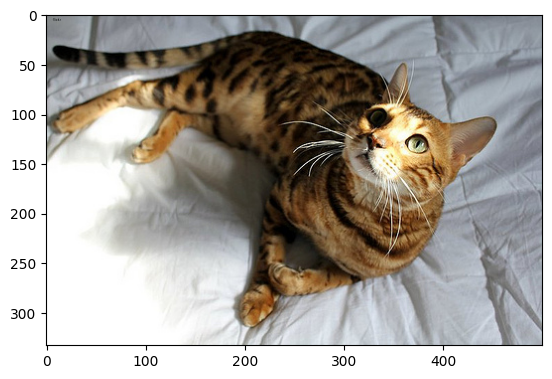

In [33]:
plt.imshow(plt.imread(test_img_paths[334]))

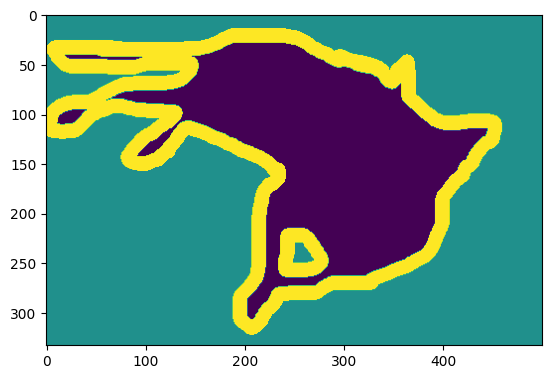

In [34]:
plt.imshow(plt.imread(test_label_paths[334]) * 64)